In [19]:
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Reshape, Conv2DTranspose,LeakyReLU, Dropout,BatchNormalization
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from google.colab import drive
from PIL import Image
import os
import random

**Data Processing**

In [20]:
path = r'/content/drive/MyDrive/CryptoPunks'
filelist = os.listdir(path)
lst = []
for file in filelist:
  img = Image.open(path+'/'+file)
  img = img.convert('RGB')
  arr = np.array(img)
  lst.append(arr)

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
x_train = lst[:8000]
x_train = np.array(x_train)

x_test = lst[8000:10000]
x_test = np.array(x_test)

print(x_train.min(),x_train.max())
x_train = (x_train - 127.5) / 127.5  # Normalize the images to [-1, 1]
print(x_train.min(),x_train.max())
print(x_train.shape)

0 255
-1.0 1.0
(8000, 24, 24, 3)


In [23]:
def display_images(images):
  for i in range(20):    
    plt.subplot(4, 5, i + 1)
    img = np.uint8(images[i] * 127.5 + 127.5) #revert to 0..255
    plt.imshow(img.reshape(24,24,3))      
  plt.show()

In [24]:
D_loss=[] #list to collect loss for the discriminator model
D_acc=[] #list to collect accuracy for the discriminator model
G_loss=[] #list to collect loss for generator model

**Discriminator**

In [25]:
discriminator = Sequential()
in_shape = (24,24,3)
discriminator.add(Conv2D(64, (2,2), padding='same', input_shape=in_shape))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Conv2D(64, (2,2), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Conv2D(64, (2,2), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Conv2D(64, (2,2), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation=tf.keras.layers.LeakyReLU()))
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9)
discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


In [26]:
discriminator.trainable = False
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 24, 24, 64)        832       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 24, 24, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 64)        16448     
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 12, 12, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 6, 6, 64)          16448     
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 6, 6, 64)          0         
                                                                 
 conv2d_7 (Conv2D)           (None, 3, 3, 64)         

**Generator**

In [27]:
latent_dim = 32
generator = Sequential()
generator.add(Dense(6 * 6 * 128, input_shape=[latent_dim]))
generator.add(Reshape([6, 6, 128]))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same",activation=LeakyReLU()))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding="same",activation="tanh"))

In [28]:
generator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 4608)              152064    
                                                                 
 reshape_1 (Reshape)         (None, 6, 6, 128)         0         
                                                                 
 batch_normalization_2 (Batc  (None, 6, 6, 128)        512       
 hNormalization)                                                 
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 12, 12, 64)       204864    
 ranspose)                                                       
                                                                 
 batch_normalization_3 (Batc  (None, 12, 12, 64)       256       
 hNormalization)                                                 
                                                      

**GAN**

In [29]:
RMS = tf.keras.optimizers.RMSprop(lr = .0001,clipvalue=1.0,decay=1e-8)
GAN = Sequential([generator,discriminator])
GAN.compile(loss='binary_crossentropy',optimizer = RMS)
GAN.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 24, 24, 3)         362499    
                                                                 
 sequential_3 (Sequential)   (None, 1)                 50753     
                                                                 
Total params: 413,252
Trainable params: 362,115
Non-trainable params: 51,137
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [30]:
batch_size = 16
epochs = 25
my_data = x_train

zeros=np.zeros(shape=(batch_size,1))
ones=np.ones(shape=(batch_size,1))

500.0

In [31]:
dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

(8000, 24, 24, 3)
(8000, 24, 24, 3)
<PrefetchDataset element_spec=TensorSpec(shape=(16, 24, 24, 3), dtype=tf.float64, name=None)>


In [32]:
noise = tf.random.normal(shape=[20, latent_dim])
images = generator(noise)

<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


**Training**

Epoch # 1


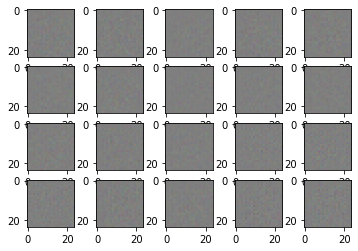

real: (16, 24, 24, 3) (16, 1)
gen:  (16, 24, 24, 3) (16, 1)
combined:  (32, 24, 24, 3) (32, 1)
noise:  (16, 32) (16, 1)
d_loss: 0.17443081736564636 d_acc: 1.0 g_loss: 5.661709785461426
Epoch # 2


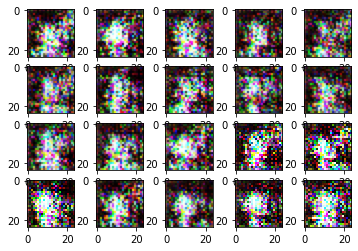

d_loss: 0.3886841833591461 d_acc: 0.84375 g_loss: 8.988898277282715
Epoch # 3


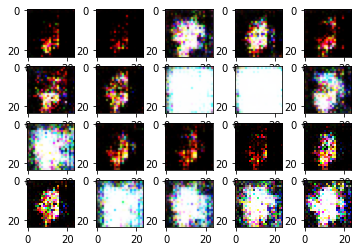

d_loss: 0.19175580143928528 d_acc: 0.96875 g_loss: 6.7569074630737305
Epoch # 4


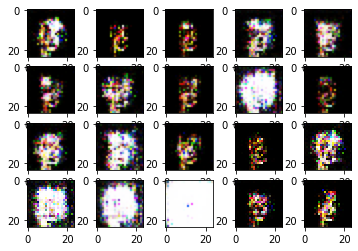

d_loss: 0.46584922075271606 d_acc: 0.78125 g_loss: 3.764284133911133
Epoch # 5


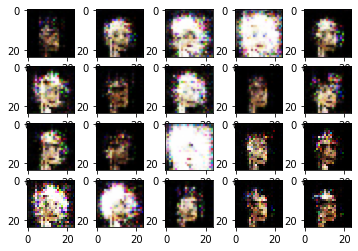

d_loss: 0.5379052758216858 d_acc: 0.78125 g_loss: 1.2174216508865356
Epoch # 6


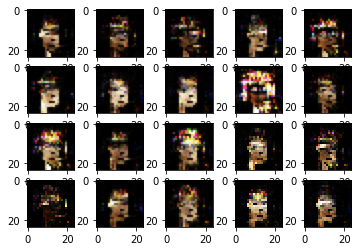

d_loss: 0.5799991488456726 d_acc: 0.6875 g_loss: 1.0661834478378296
Epoch # 7


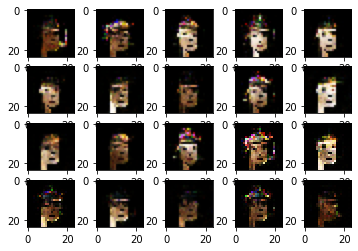

d_loss: 0.40152931213378906 d_acc: 0.96875 g_loss: 1.0950675010681152
Epoch # 8


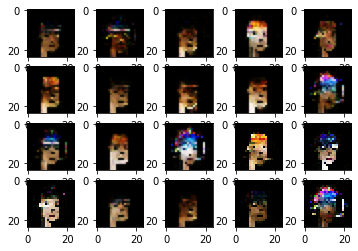

d_loss: 0.3342846930027008 d_acc: 0.78125 g_loss: 1.2217466831207275
Epoch # 9


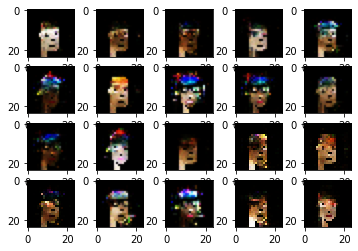

d_loss: 7.624619007110596 d_acc: 0.5 g_loss: 0.0
Epoch # 10


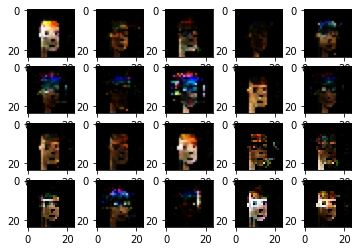

d_loss: 7.624619007110596 d_acc: 0.5 g_loss: 0.0
Epoch # 11


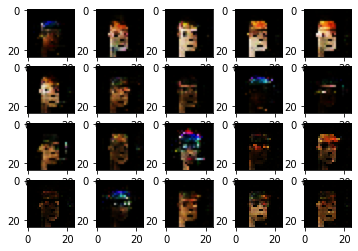

d_loss: 7.624619007110596 d_acc: 0.5 g_loss: 0.0
Epoch # 12


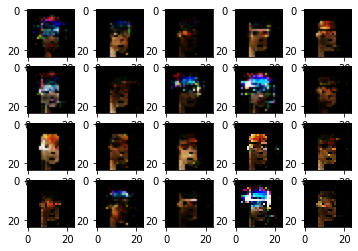

d_loss: 7.624619007110596 d_acc: 0.5 g_loss: 0.0
Epoch # 13


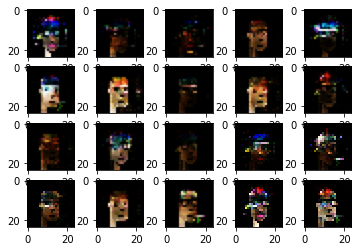

d_loss: 7.624619007110596 d_acc: 0.5 g_loss: 0.0
Epoch # 14


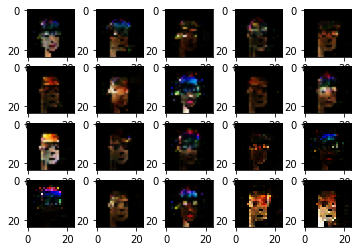

d_loss: 7.624619007110596 d_acc: 0.5 g_loss: 0.0
Epoch # 15


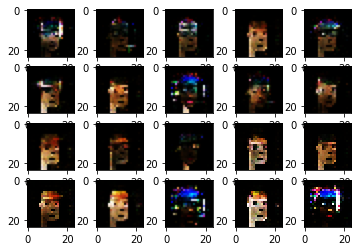

d_loss: 7.624619007110596 d_acc: 0.5 g_loss: 0.0
Epoch # 16


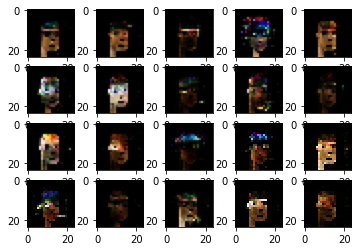

d_loss: 7.624619007110596 d_acc: 0.5 g_loss: 0.0
Epoch # 17


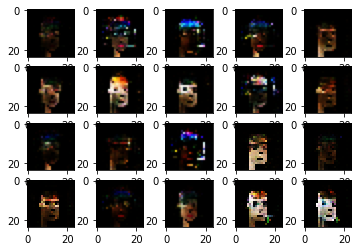

d_loss: 7.624619007110596 d_acc: 0.5 g_loss: 0.0
Epoch # 18


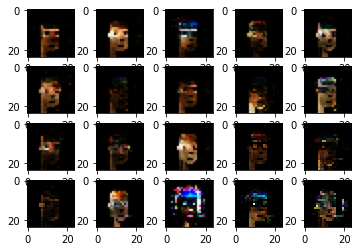

d_loss: 7.624619007110596 d_acc: 0.5 g_loss: 0.0
Epoch # 19


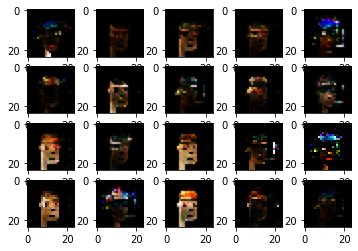

d_loss: 7.624619007110596 d_acc: 0.5 g_loss: 0.0
Epoch # 20


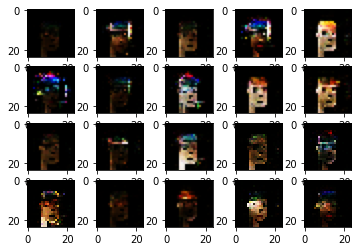

d_loss: 7.624619007110596 d_acc: 0.5 g_loss: 0.0
Epoch # 21


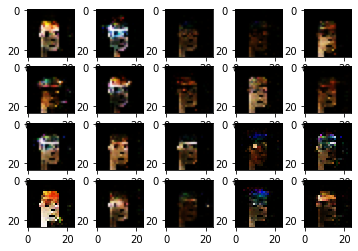

d_loss: 7.624619007110596 d_acc: 0.5 g_loss: 0.0
Epoch # 22


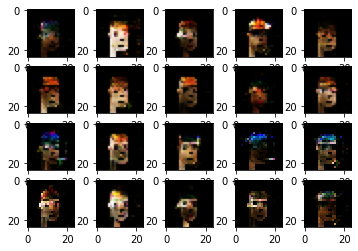

d_loss: 7.624619007110596 d_acc: 0.5 g_loss: 0.0
Epoch # 23


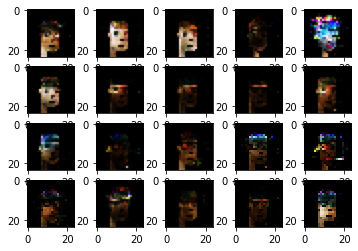

d_loss: 7.624619007110596 d_acc: 0.5 g_loss: 0.0
Epoch # 24


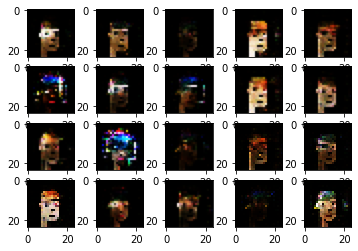

d_loss: 7.624619007110596 d_acc: 0.5 g_loss: 0.0
Epoch # 25


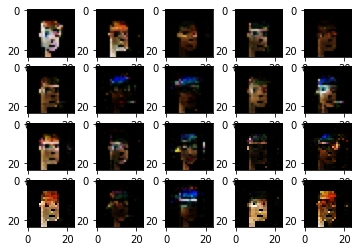

d_loss: 7.624619007110596 d_acc: 0.5 g_loss: 0.0
TRAINING COMPLETE


In [33]:
for epoch in range(epochs):

    #display plots
    print(f"Epoch # {epoch+1}")
    noise = tf.random.normal(shape=[20, latent_dim])
    images = generator(noise)
    display_images(images)    

    i = 0    
    for X_batch in dataset:
        i=i+1

        ## TRAINING THE DISCRIMINATOR ##
        
        real_images = tf.dtypes.cast(X_batch,tf.float32)        
        noise = tf.random.normal(shape=[batch_size, latent_dim])
        fake_images = generator(noise)   

        combined_images = np.concatenate([real_images,fake_images],axis=0)  # problem is real_images is shaped as (16,24,24,1) instead of (16,24,24,3) 
        combined_labels = np.concatenate([ones,zeros],axis=0)
        
        d_loss, d_acc = discriminator.train_on_batch(combined_images, combined_labels)
                
        ## TRAINING THE GENERATOR ##
        
        noise = tf.random.normal(shape=[batch_size, latent_dim])  
        g_loss = GAN.train_on_batch(noise, ones)
        
        #print shape info 
        if epoch==0 and i==1:
          print("real:" ,real_images.shape, ones.shape)
          print("gen: ", fake_images.shape, zeros.shape)
          print("combined: ",combined_images.shape,combined_labels.shape)
          print("noise: ", noise.shape, ones.shape)
        
        #append loss & accuracy 
        if i%50==49:
          D_loss.append(d_loss)
          D_acc.append(d_acc)          
          G_loss.append(g_loss)    
    
    #print loss and accuracy 
    print(f"d_loss: {d_loss} d_acc: {d_acc} g_loss: {g_loss}")    
      
print("TRAINING COMPLETE")            